In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # <--- NEW IMPORT
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, t # <--- NEW IMPORT for CI
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt
import time

# ==========================================
# CONFIGURATION
# ==========================================
FS = 128

root_path = Path.cwd().parent
data_path = root_path / "data" / "raw"

bands = {
    'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13),
    'beta': (13, 30), 'gamma': (30, 45)
}

# ==========================================
# FEATURE EXTRACTION FUNCTIONS
# ==========================================
def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def permutation_entropy(time_series, order=3, delay=1):
    n = len(time_series)
    if n < order * delay: return 0
    permutations = np.array([time_series[i:i + order * delay:delay] for i in range(n - (order - 1) * delay)])
    sorted_idx = np.argsort(permutations, axis=1)
    patterns, counts = np.unique(sorted_idx, axis=0, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-10))

def spike_detection(signal, threshold=3):
    spikes = np.where(np.abs(signal - np.mean(signal)) > threshold * np.std(signal))[0]
    return len(spikes)

def band_features(signal, fs):
    de_sq_list = []
    spike_list = []
    for band_name in bands:
        lowcut, highcut = bands[band_name]
        try:
            filtered = bandpass_filter(signal, fs, lowcut, highcut)
            variance = np.var(filtered)
            if variance <= 0: variance = 1e-10
            de = 0.5 * np.log(2 * np.pi * np.e * variance)
            de_sq_list.append(de ** 2)
            spike_list.append(spike_detection(filtered))
        except:
            de_sq_list.append(0); spike_list.append(0)

    try:
        delta_filtered = bandpass_filter(signal, fs, 0.5, 4)
        pe_delta = permutation_entropy(delta_filtered)
    except: pe_delta = 0

    return de_sq_list + spike_list + [pe_delta]

def process_window(start, eeg_values, window_size_samples, fs):
    window = eeg_values[start:start + window_size_samples]
    if len(window) < window_size_samples: return None
    if np.all(window == 0): return None
    return band_features(window, fs)

def trim_zero_ends(eeg, bis, fs_eeg=128, fs_bis=1):
    bis = np.array(bis)
    eeg = np.array(eeg)
    bis_start_idx = next((i for i, val in enumerate(bis) if val != 0), None)
    bis_end_idx = next((i for i, val in enumerate(bis[::-1]) if val != 0), None)
    if bis_start_idx is None or bis_end_idx is None:
        return np.array([]), np.array([])
    bis_end_idx = len(bis) - bis_end_idx

    start_time = bis_start_idx / fs_bis
    end_time = bis_end_idx / fs_bis
    start_eeg_idx = int(start_time * fs_eeg)
    end_eeg_idx = int(end_time * fs_eeg)

    return eeg[start_eeg_idx:end_eeg_idx], bis[bis_start_idx:bis_end_idx]

# ==========================================
# MAIN EXECUTION
# ==========================================
def experiment(SAMPLE_LIMIT):
    window_size_seconds = 56
    step_size_seconds = 1
    advance_seconds = 60

    print("1. Loading Patient 411 Data...")
    try:
        df_eeg = pd.read_csv(data_path / 'patient411_eeg.csv')
        df_bis = pd.read_csv(data_path / 'patient411_bis.csv')

        eeg_raw = df_eeg['EEG'].interpolate('linear').values.flatten()
        bis_raw = df_bis['BIS'].interpolate('linear').values.flatten()

    except Exception as e:
        print(f"Error loading data: {e}")
        exit()

    print("2. Aligning and Trimming...")
    eeg, bis = trim_zero_ends(eeg_raw, bis_raw, fs_eeg=FS, fs_bis=1)

    if len(eeg) == 0:
        print("Data empty after trim."); exit()

    print(f"3. Extracting Features (Parallel)...")
    win_samples = int(window_size_seconds * FS)
    step_samples = int(step_size_seconds * FS)
    starts = range(0, len(eeg) - win_samples + 1, step_samples)

    t0 = time.time()
    features_raw = Parallel(n_jobs=-1)(
        delayed(process_window)(s, eeg, win_samples, FS)
        for s in starts
    )

    X = np.array([f for f in features_raw if f is not None])

    # Align Target
    advance_steps = int(advance_seconds / step_size_seconds)
    y = bis[advance_steps:]

    min_len = min(len(X), len(y))
    X = X[:min_len]
    y = y[:min_len]

    print(f"   -> Feature Extraction Time: {time.time()-t0:.1f}s")
    print(f"   -> Total Available Samples: {len(X)}")

    # Subsampling
    if SAMPLE_LIMIT and len(X) > SAMPLE_LIMIT:
        print(f"   [INFO] Subsampling to {SAMPLE_LIMIT} samples.")
        indices = np.linspace(0, len(X)-1, SAMPLE_LIMIT).astype(int)
        X = X[indices]
        y = y[indices]

    # --- ADVANTAGE 1: Standardized Splitting (Clean & Readable) ---
    # shuffle=False is critical here to respect the timeline (Scientific Validity)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )

    print("4. Training SVR (Classical RBF)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(kernel='rbf')
    model.fit(X_train_scaled, y_train)

    print("5. Evaluating...")
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)

    # --- ADVANTAGE 2: Proper Confidence Interval Calc (Corrected Math) ---
    coeffs = np.polyfit(y_pred, y_test, 1)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(y_pred), max(y_pred), 100)
    y_fit = poly(x_fit)

    # Calculate 95% CI
    n = len(y_pred)
    residuals = y_test - poly(y_pred)
    std_err = np.std(residuals)
    t_val = t.ppf(0.975, df=n-2)

    # Fixed the * 2 typo to ** 2 from the other code
    ci_band = t_val * std_err * np.sqrt(
        1/n + (x_fit - np.mean(y_pred))**2 / np.sum((y_pred - np.mean(y_pred))**2)
    )

    overall_ci = 1.96 * np.std(y_pred - y_test) / np.sqrt(n)

    print(f"\n--- RESULTS (Patient 411, N={len(X)}) ---")
    print(f"MSE     : {mse:.5f}")
    print(f"RMSE    : {rmse:.5f}")
    print(f"R2      : {r2:.5f}")
    print(f"R       : {r:.5f}")
    print(f"95% CI  : {overall_ci:.5f}")

    # Plot 1: Standard Comparison
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual BIS', alpha=0.7)
    plt.plot(y_pred, label='Predicted BIS (RBF)', linestyle='--')
    plt.legend()
    plt.title(f"Result (Patient 48)\nRMSE={rmse:.2f}, R2={r2:.2f}")
    plt.show()

1. Loading Patient 411 Data...
2. Aligning and Trimming...
3. Extracting Features (Parallel)...
   -> Feature Extraction Time: 38.6s
   -> Total Available Samples: 3799
   [INFO] Subsampling to 200 samples.
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Patient 411, N=200) ---
MSE     : 185.19653
RMSE    : 13.60869
R2      : 0.34876
R       : 0.88404
95% CI  : 4.17980


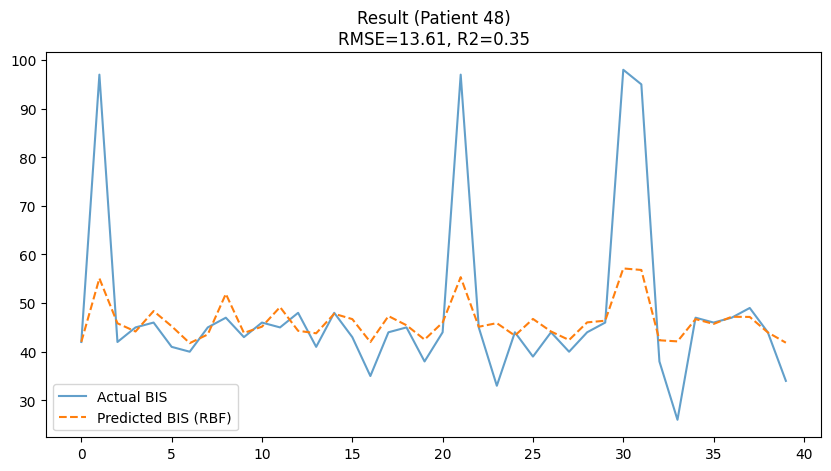

In [2]:
experiment(200)

1. Loading Patient 411 Data...
2. Aligning and Trimming...
3. Extracting Features (Parallel)...
   -> Feature Extraction Time: 24.5s
   -> Total Available Samples: 3799
   [INFO] Subsampling to 500 samples.
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Patient 411, N=500) ---
MSE     : 180.98545
RMSE    : 13.45308
R2      : 0.51624
R       : 0.87750
95% CI  : 2.53517


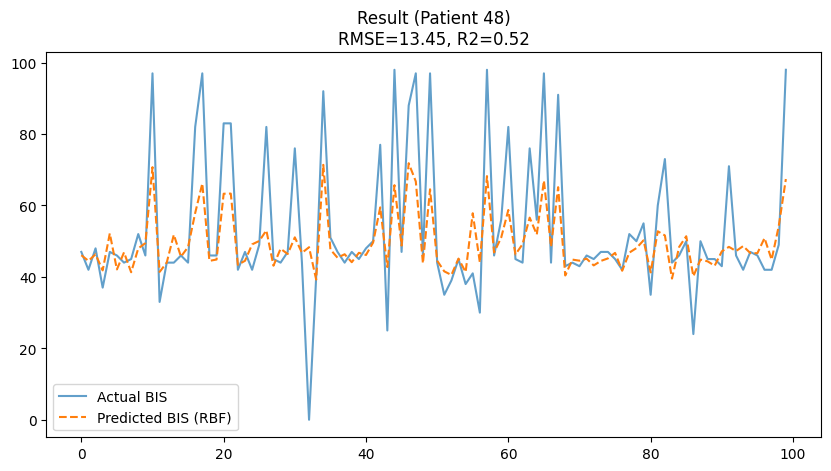

In [3]:
experiment(500)

1. Loading Patient 411 Data...
2. Aligning and Trimming...
3. Extracting Features (Parallel)...
   -> Feature Extraction Time: 22.5s
   -> Total Available Samples: 3799
   [INFO] Subsampling to 1000 samples.
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Patient 411, N=1000) ---
MSE     : 96.93375
RMSE    : 9.84549
R2      : 0.73522
R       : 0.88494
95% CI  : 1.36376


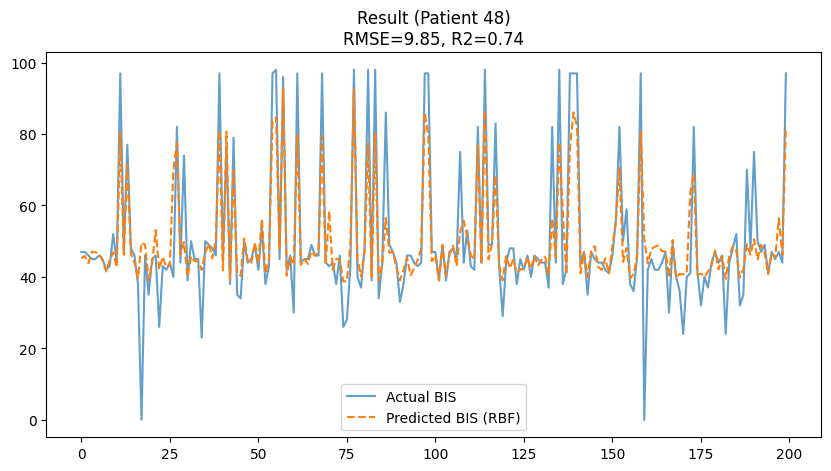

In [4]:
experiment(1000)

1. Loading Patient 411 Data...
2. Aligning and Trimming...
3. Extracting Features (Parallel)...
   -> Feature Extraction Time: 23.7s
   -> Total Available Samples: 3799
   [INFO] Subsampling to 2000 samples.
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Patient 411, N=2000) ---
MSE     : 60.14281
RMSE    : 7.75518
R2      : 0.80510
R       : 0.89902
95% CI  : 0.75787


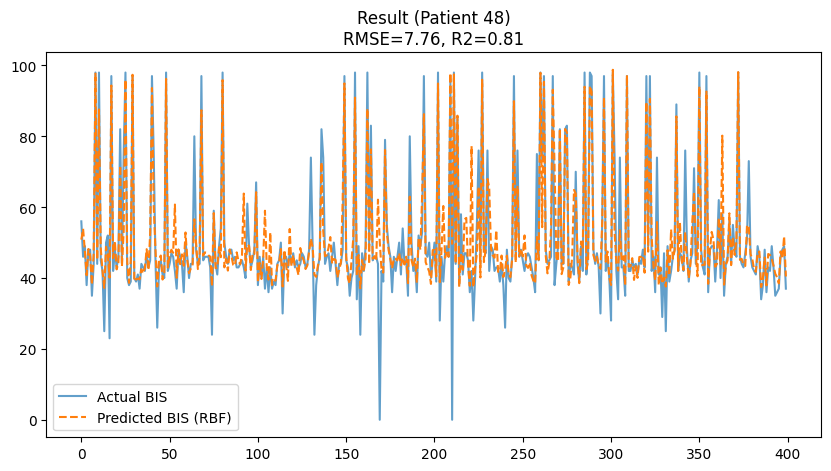

In [5]:
experiment(2000)

1. Loading Patient 411 Data...
2. Aligning and Trimming...
3. Extracting Features (Parallel)...
   -> Feature Extraction Time: 18.8s
   -> Total Available Samples: 3799
   [INFO] Subsampling to 3000 samples.
4. Training SVR (Classical RBF)...
5. Evaluating...

--- RESULTS (Patient 411, N=3000) ---
MSE     : 43.33818
RMSE    : 6.58317
R2      : 0.87733
R       : 0.93833
95% CI  : 0.52665


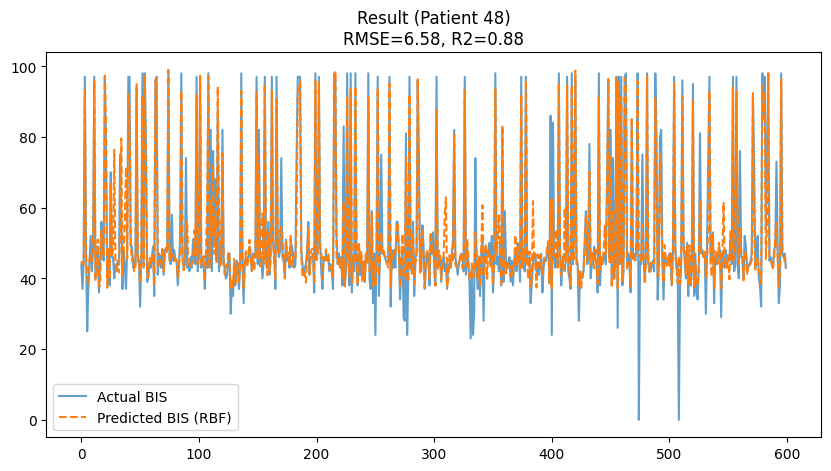

In [6]:
experiment(3000)